In [1]:
import pandas as pd
import numpy as np
import scipy

In [2]:
dd = pd.read_csv('ab_browser_test.csv')
dd.describe()
dd.info()
dd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
dd_e = dd[(dd['slot'] == 'exp')]
dd_c = dd[(dd['slot'] == 'control')]

In [4]:
round((dd_e['n_clicks'].mean() - dd_c['n_clicks'].mean()) / dd_c['n_clicks'].mean() * 100, 3)

2.687

In [25]:
round((dd_e['n_clicks'].sum() / dd_c['n_clicks'].sum() - 1) * 100, 3)

1.614

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [6]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
sample_e = dd_e['n_clicks'].to_numpy()
sample_c = dd_c['n_clicks'].to_numpy()

In [19]:
np.random.seed(0)
samples_e = get_bootstrap_samples(sample_e, 1000)
samples_c = get_bootstrap_samples(sample_c, 1000)

In [20]:
np.random.seed(0)
mean_e = np.zeros(1000)
med_e = np.zeros(1000)
mean_c = np.zeros(1000)
med_c = np.zeros(1000)

for i in np.arange(1000):
    mean_e[i] = samples_e[i].mean()
    mean_c[i] = samples_c[i].mean()
    med_e[i] = np.median(samples_e[i])
    med_c[i] = np.median(samples_c[i])

In [21]:
stat_intervals(med_e - med_c, 0.05)

array([1., 1.])

In [22]:
stat_intervals(mean_e - mean_c, 0.05)

array([0.19172563, 0.40475697])

In [23]:
sample_e.shape

(281580,)

In [27]:
import matplotlib.pyplot as plt

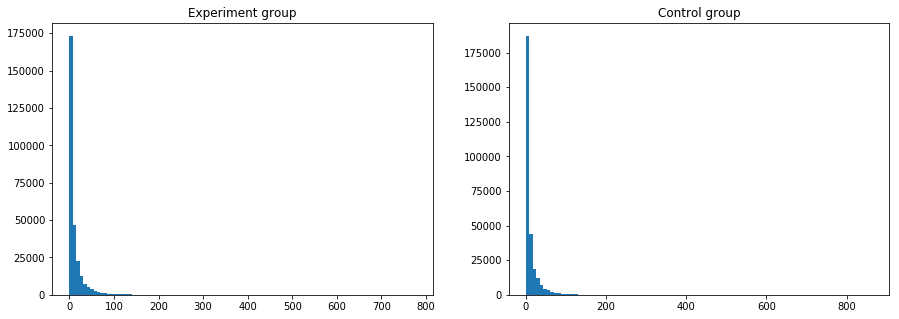

In [29]:
_ = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
_ = plt.hist(dd_e.n_clicks, bins=100)
_ = plt.title('Experiment group')
_ = plt.subplot(122)
_ = plt.hist(dd_c.n_clicks, bins=100)
_ = plt.title('Control group')

In [30]:
var_c = np.zeros(1000)

for i in np.arange(1000):
    var_c[i] = samples_c[i].var()

In [32]:
from scipy import stats

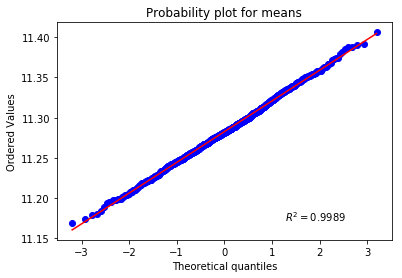

In [33]:
_ = stats.probplot(mean_c, plot=plt, rvalue=True)
_ = plt.title('Probability plot for means') #9984 on 500

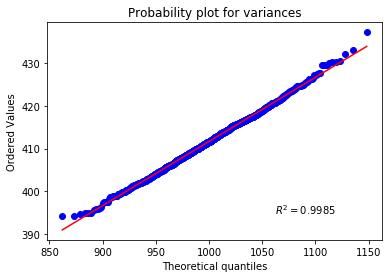

In [34]:
_ = stats.probplot(var_c, plot=plt, dist='chi2', sparams=(mean_c.shape[0]-1), rvalue=True)
_ = plt.title('Probability plot for variances') #9970 on 500

In [35]:
clicks_e = dd_e.groupby(['userID', 'browser'])['n_clicks'].sum()
clicks_c = dd_c.groupby(['userID', 'browser'])['n_clicks'].sum()

In [38]:
clicks_e.head()

userID  browser   
1       Browser #2    23
3       Browser #4     3
5       Browser #4    29
7       Browser #4    54
9       Browser #4     6
Name: n_clicks, dtype: int64

In [57]:
stats.mannwhitneyu(clicks_e, clicks_c, alternative='two-sided')[1]

6.247235801369629e-75

In [40]:
br_clicks_e = dd_e.groupby(['browser', 'userID'])['n_clicks'].sum()
br_clicks_c = dd_c.groupby(['browser', 'userID'])['n_clicks'].sum()

In [41]:
browsers_e = np.unique(dd_e.browser)

In [42]:
browsers_c = np.unique(dd_c.browser)

In [44]:
if browsers_c.all() == browsers_e.all():
    print('xiz')

xiz


In [52]:
browsers

array(['Browser #14', 'Browser #17', 'Browser #2', 'Browser #20',
       'Browser #22', 'Browser #4'], dtype=object)

In [63]:
b_clicks_test = dd_e[(dd_e['browser'] == 'Browser #14')]['n_clicks']

In [65]:
p_list = []

for b in browsers:
    b_clicks_e = dd_e[(dd_e['browser'] == b)]['n_clicks']
    b_clicks_c = dd_c[(dd_c['browser'] == b)]['n_clicks']
    p_list.append(stats.mannwhitneyu(b_clicks_e, b_clicks_c, alternative='two-sided')[1])

In [66]:
p_list

[0.0,
 0.07480120286021603,
 0.0544877208394482,
 0.9073331277747075,
 0.5148110304420064,
 0.8152123531690997]

In [68]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [69]:
_, p_c_list, _, _ = multipletests(p_list, alpha = 0.05, method = 'holm')

In [70]:
p_c_list

array([0.        , 0.29920481, 0.2724386 , 1.        , 1.        ,
       1.        ])

In [73]:
dd_e.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
4,7,Browser #4,exp,54,68,30
6,9,Browser #4,exp,6,3,1


In [83]:
dd_e.groupby(['browser'])['n_nonclk_queries'].sum()

browser
Browser #14    123656
Browser #17     77614
Browser #2     246514
Browser #20     72998
Browser #22    296177
Browser #4     456508
Name: n_nonclk_queries, dtype: int64

In [84]:
brs_noclick_e = dd_e.groupby(['browser'])['n_nonclk_queries'].sum()
brs_click_e = dd_e.groupby(['browser'])['n_queries'].sum()
p_e = brs_noclick_e / brs_click_e 

brs_noclick_c = dd_c.groupby(['browser'])['n_nonclk_queries'].sum()
brs_click_c = dd_c.groupby(['browser'])['n_queries'].sum()
p_c = brs_noclick_c / brs_click_c 

In [87]:
print('Control / experimental groups')
for i in np.arange(len(browsers)):
    print(p_c[i], p_e[i])

Control / experimental groups
0.5759041136008114 0.4375561736127329
0.36299366746282086 0.3693741284866483
0.4596274717919465 0.449827469485547
0.4054048474338329 0.3897737648371716
0.40593976593513353 0.3985394721969546
0.4697092963514274 0.4514294190358467
